# Recognition Parametrized Model (RPM): Peer Supervision


Observations $x_j$ are groups of MNIST images representing $J$ different renderings of the same digit.  
RMP infers the discrete-valued latent $\mathcal{Z}$ using a recognition network $f_\theta$ 

The RPM to extract this information without explicit label information - a setting that might be termed "peer-supervision". The model writes:

$$   P(\mathcal{X}, \mathcal{Z}) = \prod_j p_0(x_j) \frac{f_{\theta}(\mathcal{Z}|x_j)}{\frac1N \sum_n f_{\theta}(\mathcal{Z}|x_j^{(n)})}  p_0(\mathcal{Z})$$


## Load and Rearanged MNIST


In [1]:
import pickle
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

from utils import rearrange_mnist
from unstructured_recognition_1DCategorical import UnstructuredRecognition

# Load MNIST
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True,
    )

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor()
    )

# Random seeds
torch.manual_seed(2)

# Number of Conditionally independent Factors
num_factors = 2

# Sub-Sample original dataset
train_length = 60000

# Keep Only some digits
sub_ids = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
num_digits = len(sub_ids)

# Rearrange MNIST by grouping num_factors Conditionally independent Observations together
observations, train_images, train_labels = rearrange_mnist(
    train_data.train_data, train_data.train_labels, num_factors, train_length=train_length, sub_ids=sub_ids)


## Plot typical sets of conditionnally independent Observations

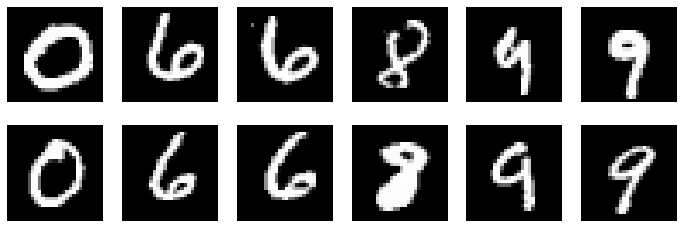

In [2]:
num_plot = np.arange(6)
plt.figure(figsize=(len(num_plot)*2, num_factors*2))
for obsi in range(len(num_plot)):
    for facti in range(num_factors):
        plt.subplot(num_factors, len(num_plot), (1+obsi) + facti * len(num_plot))
        plt.imshow(observations[facti][num_plot[obsi], :, :], cmap='gray')
        plt.axis('off')

## Fit

In [3]:
# Fit Parameters
fit_params = {"ite_max": 400}

# Init Model
model = UnstructuredRecognition(num_digits, observations, fit_params=fit_params)

# Fit model
model.fit(observations)


Iteration :1/400 Loss 14992723000.0
Iteration :2/400 Loss 14992692000.0
Iteration :3/400 Loss 14992695000.0
Iteration :4/400 Loss 14992697000.0
Iteration :5/400 Loss 14992689000.0
Iteration :6/400 Loss 14992678000.0
Iteration :7/400 Loss 14992672000.0
Iteration :8/400 Loss 14992672000.0
Iteration :9/400 Loss 14992665000.0
Iteration :10/400 Loss 14992664000.0
Iteration :11/400 Loss 14992663000.0
Iteration :12/400 Loss 14992662000.0
Iteration :13/400 Loss 14992660000.0
Iteration :14/400 Loss 14992658000.0
Iteration :15/400 Loss 14992656000.0
Iteration :16/400 Loss 14992656000.0
Iteration :17/400 Loss 14992656000.0
Iteration :18/400 Loss 14992655000.0
Iteration :19/400 Loss 14992655000.0
Iteration :20/400 Loss 14992655000.0
Iteration :21/400 Loss 14992655000.0
Iteration :22/400 Loss 14992655000.0
Iteration :23/400 Loss 14992655000.0
Iteration :24/400 Loss 14992654000.0
Iteration :25/400 Loss 14992652000.0
Iteration :26/400 Loss 14992650000.0
Iteration :27/400 Loss 14992649000.0
Iteration 

Iteration :220/400 Loss 14992620000.0
Iteration :221/400 Loss 14992620000.0
Iteration :222/400 Loss 14992617000.0
Iteration :223/400 Loss 14992620000.0
Iteration :224/400 Loss 14992620000.0
Iteration :225/400 Loss 14992620000.0
Iteration :226/400 Loss 14992617000.0
Iteration :227/400 Loss 14992620000.0
Iteration :228/400 Loss 14992616000.0
Iteration :229/400 Loss 14992620000.0
Iteration :230/400 Loss 14992616000.0
Iteration :231/400 Loss 14992620000.0
Iteration :232/400 Loss 14992617000.0
Iteration :233/400 Loss 14992622000.0
Iteration :234/400 Loss 14992620000.0
Iteration :235/400 Loss 14992622000.0
Iteration :236/400 Loss 14992620000.0
Iteration :237/400 Loss 14992620000.0
Iteration :238/400 Loss 14992617000.0
Iteration :239/400 Loss 14992620000.0
Iteration :240/400 Loss 14992617000.0
Iteration :241/400 Loss 14992620000.0
Iteration :242/400 Loss 14992620000.0
Iteration :243/400 Loss 14992617000.0
Iteration :244/400 Loss 14992617000.0
Iteration :245/400 Loss 14992617000.0
Iteration :2

## Process Fit

Training Accuracy = 0.955
Testing  Accuracy = 0.957


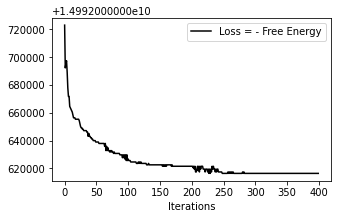

In [18]:
# Deactivate dropouts
model.recognition_network.eval()

# Grasp Test set
test_images = test_data.test_data[torch.isin(test_data.test_labels, sub_ids)]
test_labels = test_data.test_labels[torch.isin(test_data.test_labels, sub_ids)]

# Reduce training set
reduce_training_set = 20000

# Convert Test datasets
test_tmp = test_images.clone().detach().float() #torch.tensor(, dtype=torch.float32)

# Use Recognition Network to classify digits
train_predictions =\
    torch.argmax(model.recognition_network.forward(train_images[:reduce_training_set].unsqueeze(dim=1)), dim=1)
test_predictions = \
    torch.argmax(model.recognition_network.forward(test_tmp.unsqueeze(dim=1)), dim=1)

# Find best permutation between model clusters and digits identity
perm_opt = model.permute_prediction(train_predictions, train_labels[:reduce_training_set], sub_ids)

# Permute Labels
train_predictions = perm_opt[train_predictions]
test_predictions = perm_opt[test_predictions]

# Train / Test performances
train_accuracy = sum(abs(train_predictions-train_labels[:reduce_training_set]) < 0.1) / reduce_training_set
test_accuracy = sum(abs(test_predictions-test_labels) < 0.01 ) / len(test_labels)

# Summary
train_results = str(np.round(train_accuracy.numpy(), 3))
test_results = str(np.round(test_accuracy.numpy(), 3))

# Plot And print summary
plt.figure(figsize=(5,3))
plt.plot(model.loss_tot, color='k', label='Loss = - Free Energy')
plt.legend()
plt.xlabel('Iterations')


print('Training Accuracy = ' + train_results)
print('Testing  Accuracy = ' + test_results)
